# 6. Create Feature View for Model Training

Join all engineered feature groups and create targets for QQQ prediction.

**Pipeline**: Hopsworks FGs (engineered) → Read with fallback → Join → Create Targets → Upload → Feature View

**Note**: Attempts to read from Hopsworks using multiple methods. Falls back to re-creating features if all reads fail.

**Key Components**:
- **Feature Join**: Time-aligned merge of all feature groups on date
- **Target Creation**: Next-day return (regression) and direction (classification)
- **Missing Value Handling**: Drop NaN from rolling windows, fill sentiment with 0
- **Feature View**: Hopsworks object for training data access

**Critical**: Targets use `.shift(-1)` which is safe because we drop the last row (no future data available)

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

# Force reload of modules to get latest changes
import importlib
if 'utils.feature_functions' in sys.modules:
    importlib.reload(sys.modules['utils.feature_functions'])
if 'utils.hopsworks_helpers' in sys.modules:
    importlib.reload(sys.modules['utils.hopsworks_helpers'])
if 'utils.data_fetchers' in sys.modules:
    importlib.reload(sys.modules['utils.data_fetchers'])

from utils.hopsworks_helpers import get_feature_store, create_feature_group
from dotenv import load_dotenv
import yaml

load_dotenv()

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [2]:
# Disable FORCE_FALLBACK to read from Hopsworks
FORCE_FALLBACK = False
print("FORCE_FALLBACK disabled: will read features from Hopsworks.")

FORCE_FALLBACK disabled: will read features from Hopsworks.


## Connect to Hopsworks and Load Feature Groups

In [3]:
# Connect to Hopsworks
print("Connecting to Hopsworks...")
fs = get_feature_store()
print(f"✓ Connected to feature store: {fs.name}")

Connecting to Hopsworks...
2026-01-03 18:26:20,509 INFO: Initializing external client
2026-01-03 18:26:20,510 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-03 18:26:22,854 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to feature store: scalable_lab1_featurestore


In [4]:
# Load required feature groups
print("Loading feature group metadata...")

if 'FORCE_FALLBACK' in globals() and FORCE_FALLBACK:
    print("FORCE_FALLBACK enabled: skipping feature group metadata load.")
    qqq_tech_fg = xlk_sector_fg = vix_vol_fg = macro_fg = qqq_raw_fg = sentiment_fg = None
    has_sentiment = False
else:
    qqq_tech_fg = fs.get_feature_group('qqq_technical_features', version=1)
    xlk_sector_fg = fs.get_feature_group('xlk_sector_features', version=1)
    vix_vol_fg = fs.get_feature_group('vix_volatility_features', version=1)
    macro_fg = fs.get_feature_group('macro_features', version=1)
    qqq_raw_fg = fs.get_feature_group('qqq_raw', version=1)

    print("✓ Required feature groups loaded")

    # Try to load optional sentiment features
    has_sentiment = False
    try:
        sentiment_fg = fs.get_feature_group('sentiment_features', version=1)
        has_sentiment = True
        print("✓ Sentiment features found (optional)")
    except Exception as e:
        print(f"⚠ Sentiment features not found (optional)")
        print("  Proceeding without sentiment data...")


Loading feature group metadata...
✓ Required feature groups loaded
✓ Sentiment features found (optional)


## Read Feature Groups with Multiple Fallback Methods

Tries multiple read approaches to work around Hopsworks free tier limitations.

In [5]:
def read_feature_group_with_fallback(fg, name):
    """
    Try multiple methods to read a feature group.
    Returns DataFrame or None if all methods fail.
    """
    print(f"\nReading {name}...")
    
    # Method 1: Default read()
    try:
        df = fg.read()
        print(f"  ✓ SUCCESS with read(): {df.shape}")
        return df
    except Exception as e:
        print(f"  ✗ read() failed: {type(e).__name__}")
    
    # Method 2: read() with use_hive
    try:
        df = fg.read(read_options={"use_hive": True})
        print(f"  ✓ SUCCESS with read(use_hive=True): {df.shape}")
        return df
    except Exception as e:
        print(f"  ✗ read(use_hive=True) failed: {type(e).__name__}")
    
    # Method 3: select_all().read()
    try:
        df = fg.select_all().read()
        print(f"  ✓ SUCCESS with select_all().read(): {df.shape}")
        return df
    except Exception as e:
        print(f"  ✗ select_all().read() failed: {type(e).__name__}")
    
    # Method 4: Explicit column selection
    try:
        col_names = [f.name for f in fg.features]
        query = fg.select(col_names)
        df = query.read()
        print(f"  ✓ SUCCESS with explicit column select: {df.shape}")
        return df
    except Exception as e:
        print(f"  ✗ Explicit column select failed: {type(e).__name__}")
    
    print(f"  ❌ All read methods failed for {name}")
    return None

In [6]:
# Read all feature groups
print("="*60)
print("Attempting to read feature groups from Hopsworks...")
print("="*60)

if 'FORCE_FALLBACK' in globals() and FORCE_FALLBACK:
    print("FORCE_FALLBACK enabled: skipping Hopsworks reads and using local fallback path.")
    qqq_tech = xlk_sector = vix_vol = macro = qqq_raw = sentiment = None
else:
    qqq_tech = read_feature_group_with_fallback(qqq_tech_fg, 'QQQ Technical Features')
    xlk_sector = read_feature_group_with_fallback(xlk_sector_fg, 'XLK Sector Features')
    vix_vol = read_feature_group_with_fallback(vix_vol_fg, 'VIX Volatility Features')
    macro = read_feature_group_with_fallback(macro_fg, 'Macro Features')
    qqq_raw = read_feature_group_with_fallback(qqq_raw_fg, 'QQQ Raw (for target)')

    if has_sentiment:
        sentiment = read_feature_group_with_fallback(sentiment_fg, 'Sentiment Features')
    else:
        sentiment = None

print("" + "="*60)
print("Read Summary:")
print("="*60)
print(f"QQQ Technical: {'✓ SUCCESS' if qqq_tech is not None else '✗ FAILED'}")
print(f"XLK Sector: {'✓ SUCCESS' if xlk_sector is not None else '✗ FAILED'}")
print(f"VIX Volatility: {'✓ SUCCESS' if vix_vol is not None else '✗ FAILED'}")
print(f"Macro: {'✓ SUCCESS' if macro is not None else '✗ FAILED'}")
print(f"QQQ Raw: {'✓ SUCCESS' if qqq_raw is not None else '✗ FAILED'}")
if has_sentiment:
    print(f"Sentiment: {'✓ SUCCESS' if sentiment is not None else '✗ FAILED'}")


Attempting to read feature groups from Hopsworks...

Reading QQQ Technical Features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
  ✓ SUCCESS with read(): (750, 12)

Reading XLK Sector Features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
  ✓ SUCCESS with read(): (750, 5)

Reading VIX Volatility Features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
  ✓ SUCCESS with read(): (750, 7)

Reading Macro Features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 
  ✓ SUCCESS with read(): (750, 7)

Reading QQQ Raw (for target)...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 
  ✓ SUCCESS with read(): (750, 6)

Reading Sentiment Features...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 
  ✓ SUCCESS with read(): (29, 7)
Read Summary:
QQQ Technical: ✓ SUC

## Fallback: Re-create Features if Hopsworks Read Failed

In [7]:
# Check if we need fallback
need_fallback = (
    qqq_tech is None or 
    xlk_sector is None or 
    vix_vol is None or 
    macro is None or 
    qqq_raw is None
)

if need_fallback:
    print("\n" + "!"*60)
    print("⚠️  Some feature groups could not be read from Hopsworks")
    print("   Activating fallback: Re-creating features in memory...")
    print("!"*60 + "\n")
    
    # Import necessary functions for fallback
    from utils.feature_functions import (
        calculate_returns, calculate_rolling_volatility, calculate_rsi,
        calculate_ma_ratios, calculate_rolling_correlation,
        make_macro_daily_features
    )
    from utils.data_fetchers import fetch_yahoo_data, fetch_dgs10, fetch_cpi
    
    # Fetch raw data
    print("Step 1: Fetching raw data...")
    qqq_df = fetch_yahoo_data('QQQ', config['data']['start_date'], config['data']['end_date'])
    xlk_df = fetch_yahoo_data('XLK', config['data']['start_date'], config['data']['end_date'])
    vix_df = fetch_yahoo_data('^VIX', config['data']['start_date'], config['data']['end_date'])
    dgs10_df = fetch_dgs10(config['data']['start_date'], config['data']['end_date'])
    cpi_df = fetch_cpi(config['data']['start_date'], config['data']['end_date'])
    
    # Rename columns
    qqq_df = qqq_df.rename(columns={
        'open': 'qqq_open', 'high': 'qqq_high', 'low': 'qqq_low',
        'close': 'qqq_close', 'volume': 'qqq_volume'
    })
    xlk_df = xlk_df.rename(columns={
        'open': 'xlk_open', 'high': 'xlk_high', 'low': 'xlk_low',
        'close': 'xlk_close', 'volume': 'xlk_volume'
    })
    vix_df = vix_df.rename(columns={
        'open': 'vix_open', 'high': 'vix_high', 'low': 'vix_low',
        'close': 'vix_close', 'volume': 'vix_volume'
    })
    
    print(f"✓ Raw data fetched")
    
    # Create QQQ technical features
    if qqq_tech is None:
        print("\nStep 2: Creating QQQ technical features...")
        qqq_tech = qqq_df.copy()
        qqq_tech = calculate_returns(qqq_tech, 'qqq_close', config['features']['technical']['return_lags'])
        qqq_tech = calculate_rolling_volatility(qqq_tech, 'qqq_close', config['features']['technical']['volatility_windows'])
        qqq_tech = calculate_rsi(qqq_tech, 'qqq_close', config['features']['technical']['rsi_period'])
        qqq_tech = calculate_ma_ratios(qqq_tech, 'qqq_close', config['features']['technical']['ma_periods'])
        qqq_tech_cols = ['date'] + [col for col in qqq_tech.columns if col.startswith(('return_', 'volatility_', 'rsi_', 'ma_ratio_'))]
        qqq_tech = qqq_tech[qqq_tech_cols]
        print(f"✓ QQQ technical: {qqq_tech.shape}")
    
    # Create XLK sector features
    if xlk_sector is None:
        print("\nStep 3: Creating XLK sector features...")
        xlk_features = calculate_returns(xlk_df, 'xlk_close', [1, 5])
        correlation_df = calculate_rolling_correlation(
            qqq_df, xlk_df, 'qqq_close', 'xlk_close',
            config['features']['sector']['correlation_windows']
        )
        xlk_sector = xlk_features.merge(correlation_df, on='date', how='left')
        xlk_sector_cols = ['date'] + [col for col in xlk_sector.columns if col.startswith(('return_', 'corr_'))]
        xlk_sector = xlk_sector[xlk_sector_cols]
        print(f"✓ XLK sector: {xlk_sector.shape}")
    
    # Create VIX volatility features
    if vix_vol is None:
        print("\nStep 4: Creating VIX volatility features...")
        vix_vol = vix_df.copy()
        vix_vol['vix_change'] = vix_vol['vix_close'].diff()
        vix_vol['vix_pct_change'] = vix_vol['vix_close'].pct_change()
        vix_vol['vix_ma_20'] = vix_vol['vix_close'].rolling(20).mean()
        vix_vol['vix_std_20'] = vix_vol['vix_close'].rolling(20).std()
        vix_vol['vix_ma_ratio'] = vix_vol['vix_close'] / vix_vol['vix_ma_20']
        vix_vol = vix_vol[['date', 'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio']]
        print(f"✓ VIX volatility: {vix_vol.shape}")
    
    # Create macro features
    if macro is None:
        print("\nStep 5: Creating macro features...")
        trading_dates = pd.to_datetime(qqq_df['date'].unique())
        trading_dates = pd.DatetimeIndex(sorted(trading_dates))
        macro = make_macro_daily_features(
            trading_dates=trading_dates,
            dgs10_series=dgs10_df,
            cpi_series=cpi_df,
            method="fixed_release"
        )
        print(f"✓ Macro features: {macro.shape}")
    
    # Get QQQ raw
    if qqq_raw is None:
        print("\nStep 6: Preparing QQQ raw for target...")
        qqq_raw = qqq_df.copy()
        print(f"✓ QQQ raw: {qqq_raw.shape}")
    
    # Handle sentiment fallback
    if has_sentiment and sentiment is None:
        print("\nStep 7: Creating empty sentiment features (fallback)...")
        sentiment = pd.DataFrame({
            'date': qqq_df['date'],
            'sentiment_mean': 0.0,
            'sentiment_std': 0.0,
            'article_count': 0,
            'positive_mean': 0.0,
            'negative_mean': 0.0,
            'neutral_mean': 0.0
        })
        print(f"✓ Empty sentiment features created")
    
    print("\n✓ All features ready (via fallback)")
else:
    print("\n✓ All features successfully read from Hopsworks!")


✓ All features successfully read from Hopsworks!


## Preview Feature Groups

In [8]:
# Preview feature groups
print("\nQQQ Technical Features:")
print(qqq_tech.head())
print(f"\nColumns: {qqq_tech.columns.tolist()}")


QQQ Technical Features:
                       date  return_1d  return_2d  return_3d  return_5d  \
0 2025-05-09 00:00:00+00:00        NaN        NaN        NaN        NaN   
1 2023-12-20 00:00:00+00:00  -0.180499        NaN        NaN        NaN   
2 2025-01-07 00:00:00+00:00   0.286380   0.054190        NaN        NaN   
3 2025-10-03 00:00:00+00:00   0.175238   0.511803   0.238923        NaN   
4 2023-03-15 00:00:00+00:00  -0.512560  -0.427142  -0.263087        NaN   

   volatility_5d  volatility_10d  volatility_20d  rsi_14  ma_ratio_10  \
0            NaN             NaN             NaN     NaN          NaN   
1            NaN             NaN             NaN     NaN          NaN   
2            NaN             NaN             NaN     NaN          NaN   
3            NaN             NaN             NaN     NaN          NaN   
4            NaN             NaN             NaN     NaN          NaN   

   ma_ratio_20  ma_ratio_50  
0          NaN          NaN  
1          NaN          N

## Join All Feature Groups

Perform time-aligned left joins on the date column:
- Start with QQQ technical features (base)
- Left join all other feature groups
- Sentiment features filled with 0 if missing (no news that day)

In [9]:
print("Joining feature groups...")

# Start with QQQ technical features as base
features = qqq_tech.copy()

# Join XLK sector features
features = features.merge(xlk_sector, on='date', how='left', suffixes=('', '_xlk'))

# Join VIX volatility features
features = features.merge(vix_vol, on='date', how='left', suffixes=('', '_vix'))

# Join macro features
features = features.merge(macro, on='date', how='left', suffixes=('', '_macro'))

# Join sentiment features if available
if has_sentiment and sentiment is not None:
    features = features.merge(sentiment, on='date', how='left', suffixes=('', '_sent'))
    print("✓ Sentiment features included")

# Add raw QQQ close for target calculation
features = features.merge(qqq_raw[['date', 'qqq_close']], on='date', how='left')

# Sort by date
features = features.sort_values('date').reset_index(drop=True)

print(f"\n✓ Combined features shape: {features.shape}")
print(f"  Total columns: {len(features.columns)}")
print(f"  Date range: {features['date'].min()} to {features['date'].max()}")

Joining feature groups...
✓ Sentiment features included

✓ Combined features shape: (750, 35)
  Total columns: 35
  Date range: 2023-01-03 00:00:00+00:00 to 2025-12-29 00:00:00+00:00


In [10]:
# Preview combined features
print("\nCombined features preview:")
features.head(10)


Combined features preview:


,date,return_1d,return_2d,return_3d,return_5d,volatility_5d,volatility_10d,volatility_20d,rsi_14,ma_ratio_10,...,dgs10_chg_20d,cpi_level_asof,cpi_yoy_asof,sentiment_mean,sentiment_std,article_count,positive_mean,negative_mean,neutral_mean,qqq_close
0,2023-01-03 00:00:00+00:00,-0.458718,-0.476952,0.011086,-0.400404,0.547374,0.398171,0.371704,46.898858,0.684251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.795868
1,2023-01-04 00:00:00+00:00,-0.169236,-0.543017,-0.347257,-0.488923,0.324948,0.242732,0.311013,42.575942,0.628107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.033569
2,2023-01-05 00:00:00+00:00,-0.311713,-0.406978,-0.287850,-0.304838,0.201244,0.209610,0.295288,42.272148,0.606663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.947296
3,2023-01-06 00:00:00+00:00,-0.097442,-0.383788,-0.299833,-0.409583,0.165927,0.258099,0.350435,43.586470,0.735889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.039368
4,2023-01-09 00:00:00+00:00,-0.435630,-0.270832,-0.487172,-0.279143,0.392624,0.455249,0.447592,42.920786,0.612878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.748627
5,2023-01-10 00:00:00+00:00,-0.257587,-0.028971,-0.446513,-0.161898,0.420544,0.328785,0.288661,45.470924,0.613884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.997986
6,2023-01-11 00:00:00+00:00,-0.546686,-0.396895,-0.460777,-0.563009,0.570057,0.529149,0.481431,43.152424,0.592064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272.634399
7,2023-01-12 00:00:00+00:00,-0.249237,-0.497652,-0.549872,-0.418669,0.521476,0.468688,0.436826,49.317077,0.621934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.107849
8,2023-01-13 00:00:00+00:00,-0.429999,-0.461654,-0.136893,-0.519028,0.407043,0.308675,0.278582,44.782886,0.588613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.993805
9,2023-01-17 00:00:00+00:00,-0.229934,-0.272087,-0.456506,-0.193155,0.238404,0.236168,0.188083,43.835739,0.731227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.553802


## Create Target Variables

**Target 1**: `target_return` (regression)
- Next-day percentage return of QQQ
- Calculated as: `(close_t+1 / close_t) - 1`
- Uses `.shift(-1)` which is safe because we drop the last row

**Target 2**: `target_direction` (classification)
- Binary: 1 if next-day return > 0, else 0
- For up/down prediction

**Important**: The last row will have NaN targets (no future data), so we drop it.

In [11]:
print("Creating target variables...")

# Target 1: Next-day return (regression)
# shift(-1) gets tomorrow's close, then calculate return
features['next_day_close'] = features['qqq_close'].shift(-1)
features['target_return'] = (features['next_day_close'] / features['qqq_close']) - 1

# Target 2: Binary up/down (classification)
features['target_direction'] = (features['target_return'] > 0).astype(int)

# Drop temporary column
features = features.drop(columns=['next_day_close'])

print(f"\n✓ Targets created")
print(f"\nTarget statistics:")
print(features['target_return'].describe())

Creating target variables...

✓ Targets created

Target statistics:
count    749.000000
mean       0.001243
std        0.012604
min       -0.062109
25%       -0.004682
50%        0.001563
75%        0.008061
max        0.120031
Name: target_return, dtype: float64


In [12]:
# Analyze target distribution
print("\nTarget distribution (classification):")
print(features['target_direction'].value_counts())
print(f"\nUp days: {(features['target_direction'] == 1).sum()} ({(features['target_direction'] == 1).mean()*100:.1f}%)")
print(f"Down days: {(features['target_direction'] == 0).sum()} ({(features['target_direction'] == 0).mean()*100:.1f}%)")


Target distribution (classification):
target_direction
1    433
0    317
Name: count, dtype: int64

Up days: 433 (57.7%)
Down days: 317 (42.3%)


## Handle Missing Values

Missing values come from:
1. **Rolling windows**: First N rows have NaN for N-day features
2. **Sentiment**: Some days may have no news articles
3. **Target**: Last row has NaN (no future data)

Strategy:
- Fill sentiment features with 0 (no news = neutral sentiment)
- Drop rows with NaN targets
- Drop remaining NaN (from rolling windows at start)

In [13]:
# Check missing values before handling
print("Missing values per column:")
missing = features.isnull().sum()
missing_cols = missing[missing > 0].sort_values(ascending=False)
print(missing_cols.head(20))
print(f"\nTotal rows with any missing: {features.isnull().any(axis=1).sum()}")

Missing values per column:
sentiment_std     731
negative_mean     731
sentiment_mean    731
positive_mean     731
neutral_mean      731
article_count     731
cpi_yoy_asof      301
corr_60d           59
cpi_level_asof     49
ma_ratio_50        49
dgs10_chg_20d      20
volatility_20d     20
vix_ma_ratio       19
vix_std_20         19
vix_ma_20          19
corr_20d           19
ma_ratio_20        19
rsi_14             13
volatility_10d     10
ma_ratio_10         9
dtype: int64

Total rows with any missing: 742


In [14]:
# Handle sentiment features (fill with 0 if no news)
if has_sentiment and sentiment is not None:
    sentiment_cols = [col for col in features.columns if 'sentiment' in col.lower() or col in ['article_count', 'positive_mean', 'negative_mean', 'neutral_mean']]
    print(f"\nFilling {len(sentiment_cols)} sentiment columns with 0 (no news)...")
    for col in sentiment_cols:
        features[col] = features[col].fillna(0)
    print("✓ Sentiment features filled")

# Drop rows with missing targets (last row)
features_with_targets = features.dropna(subset=['target_return', 'target_direction'])
print(f"\n✓ Dropped {len(features) - len(features_with_targets)} rows with missing targets")

# Drop remaining rows with NaN (rolling window initialization)
features_clean = features_with_targets.dropna()
print(f"✓ Dropped {len(features_with_targets) - len(features_clean)} rows with NaN from rolling windows")

print(f"\nFinal clean dataset shape: {features_clean.shape}")
print(f"Date range: {features_clean['date'].min()} to {features_clean['date'].max()}")
print(f"Total training samples: {len(features_clean)}")


Filling 6 sentiment columns with 0 (no news)...
✓ Sentiment features filled

✓ Dropped 1 rows with missing targets
✓ Dropped 345 rows with NaN from rolling windows

Final clean dataset shape: (404, 37)
Date range: 2024-02-20 00:00:00+00:00 to 2025-12-24 00:00:00+00:00
Total training samples: 404


In [15]:
# Verify no missing values remain
remaining_missing = features_clean.isnull().sum().sum()
print(f"\nRemaining missing values: {remaining_missing}")
if remaining_missing > 0:
    print("WARNING: Still have missing values!")
    print(features_clean.isnull().sum()[features_clean.isnull().sum() > 0])
else:
    print("✓ No missing values in clean dataset")


Remaining missing values: 0
✓ No missing values in clean dataset


## Analyze Feature Correlations with Target

In [16]:
# Calculate correlations with target_return
feature_cols = [col for col in features_clean.columns 
                if col not in ['date', 'qqq_close', 'target_return', 'target_direction']]

correlations = features_clean[feature_cols].corrwith(features_clean['target_return']).sort_values(ascending=False)

print("Top 10 features positively correlated with next-day return:")
print(correlations.head(10))
print("\nTop 10 features negatively correlated with next-day return:")
print(correlations.tail(10))

Top 10 features positively correlated with next-day return:
vix_close         0.132921
vix_std_20        0.112728
vix_ma_ratio      0.108519
vix_ma_20         0.095714
vix_pct_change    0.085269
vix_change        0.078819
dgs10_chg_1d      0.074336
negative_mean     0.031393
sentiment_std     0.027795
article_count     0.022085
dtype: float64

Top 10 features negatively correlated with next-day return:
return_2d       -0.015395
ma_ratio_20     -0.017062
dgs10_chg_20d   -0.018308
return_3d       -0.032475
return_5d_xlk   -0.032710
return_5d       -0.038971
cpi_yoy_asof    -0.042915
ma_ratio_50     -0.047918
volatility_5d   -0.056525
corr_60d        -0.056920
dtype: float64


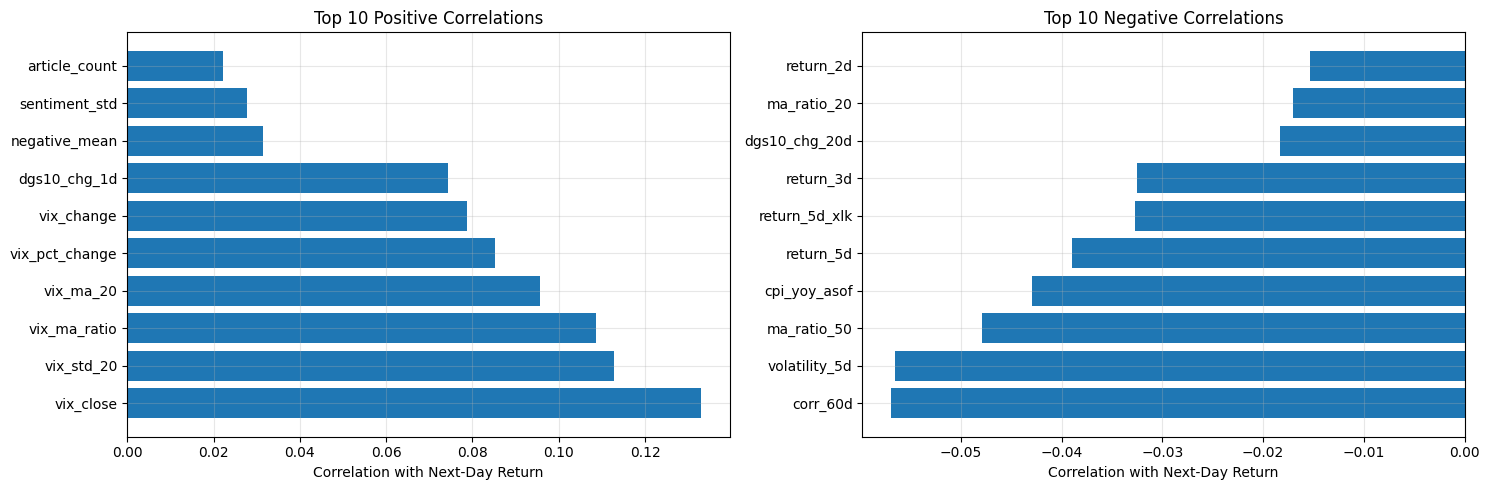


✓ Feature correlations analyzed


In [17]:
# Visualize top correlations
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Top positive correlations
top_positive = correlations.head(10)
ax1.barh(range(len(top_positive)), top_positive.values)
ax1.set_yticks(range(len(top_positive)))
ax1.set_yticklabels(top_positive.index)
ax1.set_xlabel('Correlation with Next-Day Return')
ax1.set_title('Top 10 Positive Correlations')
ax1.grid(True, alpha=0.3)

# Top negative correlations
top_negative = correlations.tail(10).sort_values()
ax2.barh(range(len(top_negative)), top_negative.values)
ax2.set_yticks(range(len(top_negative)))
ax2.set_yticklabels(top_negative.index)
ax2.set_xlabel('Correlation with Next-Day Return')
ax2.set_title('Top 10 Negative Correlations')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature correlations analyzed")

## Upload Combined Feature Group to Hopsworks

In [18]:
# Create combined feature group with all features and targets
print("\nUploading combined feature group to Hopsworks...")

combined_fg = create_feature_group(
    fs,
    name='qqq_combined_features',
    df=features_clean,
    primary_key=['date'],
    description='Combined feature set with all engineered features and prediction targets (next-day return and direction)'
)

print(f"✓ Created feature group: qqq_combined_features (version {combined_fg.version})")
print(f"  Total features: {len(feature_cols)}")
print(f"  Total samples: {len(features_clean)}")


Uploading combined feature group to Hopsworks...

Creating feature group: qqq_combined_features
Data shape (before deduplication): (404, 37)
Data shape (after deduplication): (404, 37)
Columns: ['date', 'return_1d', 'return_2d', 'return_3d', 'return_5d', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50', 'return_1d_xlk', 'return_5d_xlk', 'corr_20d', 'corr_60d', 'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio', 'dgs10', 'dgs10_chg_1d', 'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof', 'sentiment_mean', 'sentiment_std', 'article_count', 'positive_mean', 'negative_mean', 'neutral_mean', 'qqq_close', 'target_return', 'target_direction']
Data types:
date                datetime64[ms]
return_1d                  float64
return_2d                  float64
return_3d                  float64
return_5d                  float64
volatility_5d              float64
volatility_10d          

Uploading Dataframe: 100.00% |██████████| Rows 404/404 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: qqq_combined_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/qqq_combined_features_1_offline_fg_materialization/executions
2026-01-03 18:27:02,510 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-03 18:27:05,752 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-03 18:28:53,785 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2026-01-03 18:29:00,253 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-03 18:29:00,468 INFO: Waiting for log aggregation to finish.
2026-01-03 18:29:09,774 INFO: Execution finished successfully.
✓ Insert job completed
  Job details: (Job('qqq_combined_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...

✓ Upload

## Create Feature View for Model Training

A Feature View in Hopsworks:
- Defines which features to use for training
- Specifies target labels
- Enables time-series splits
- Provides consistent train/test data access

In [19]:
# Select features and labels for feature view
# Exclude: date (not a feature), qqq_close (raw price), targets (labels)
feature_names = [col for col in features_clean.columns 
                 if col not in ['date', 'qqq_close', 'target_return', 'target_direction']]

print(f"\nFeature View configuration:")
print(f"  Features: {len(feature_names)}")
print(f"  Labels: target_return (regression), target_direction (classification)")
print(f"\nFeature list:")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feat}")


Feature View configuration:
  Features: 33
  Labels: target_return (regression), target_direction (classification)

Feature list:
   1. return_1d
   2. return_2d
   3. return_3d
   4. return_5d
   5. volatility_5d
   6. volatility_10d
   7. volatility_20d
   8. rsi_14
   9. ma_ratio_10
  10. ma_ratio_20
  11. ma_ratio_50
  12. return_1d_xlk
  13. return_5d_xlk
  14. corr_20d
  15. corr_60d
  16. vix_close
  17. vix_change
  18. vix_pct_change
  19. vix_ma_20
  20. vix_std_20
  21. vix_ma_ratio
  22. dgs10
  23. dgs10_chg_1d
  24. dgs10_chg_5d
  25. dgs10_chg_20d
  26. cpi_level_asof
  27. cpi_yoy_asof
  28. sentiment_mean
  29. sentiment_std
  30. article_count
  31. positive_mean
  32. negative_mean
  33. neutral_mean


In [20]:
# Create query for feature view - INCLUDE DATE!
query = combined_fg.select(['date'] + feature_names + ['target_return', 'target_direction'])

# Create or get feature view
print("Creating feature view...")
feature_view = None

try:
    # Try to get existing feature view
    feature_view = fs.get_feature_view(name='qqq_prediction_fv', version=1)
    
    # If we got here, feature view exists - verify it's valid
    try:
        # Try a simple query to see if it works
        _ = feature_view.query
        print("✓ Feature view already exists and is valid: qqq_prediction_fv (version 1)")
    except Exception as query_error:
        # Feature view exists but is invalid (references deleted feature groups)
        print(f"⚠️  Feature view exists but is invalid: {type(query_error).__name__}")
        print("   Deleting old feature view and creating new one...")
        try:
            feature_view.delete()
            print("   ✓ Old feature view deleted")
        except:
            pass
        feature_view = None  # Force recreation
        
except Exception as e:
    # Feature view doesn't exist
    print(f"Feature view not found ({type(e).__name__})")
    feature_view = None

# Create new feature view if needed
if feature_view is None:
    print("Creating new feature view...")
    try:
        feature_view = fs.create_feature_view(
            name='qqq_prediction_fv',
            version=1,
            query=query,
            labels=['target_return', 'target_direction']
        )
        print("✓ Created new feature view: qqq_prediction_fv (version 1)")
    except Exception as create_error:
        error_msg = str(create_error)
        if "already exists" in error_msg:
            # Exists but couldn't be retrieved - try to delete via API
            print("⚠️  Feature view exists but couldn't be retrieved. Attempting manual deletion...")
            try:
                # Get it again and delete
                old_fv = fs.get_feature_view(name='qqq_prediction_fv', version=1)
                old_fv.delete()
                print("   ✓ Deleted via API, creating new one...")
                feature_view = fs.create_feature_view(
                    name='qqq_prediction_fv',
                    version=1,
                    query=query,
                    labels=['target_return', 'target_direction']
                )
                print("✓ Created new feature view: qqq_prediction_fv (version 1)")
            except Exception as delete_error:
                print(f"\n❌ ERROR: Could not delete old feature view")
                print(f"   Error: {delete_error}")
                print(f"\nManual fix required:")
                print(f"1. Go to Hopsworks UI: https://c.app.hopsworks.ai/p/1272010/fs/1258611")
                print(f"2. Navigate to Feature Views")
                print(f"3. Delete 'qqq_prediction_fv' version 1")
                print(f"4. Re-run this cell")
                raise
        else:
            raise

if feature_view is None:
    raise ValueError("Feature view is None after creation/retrieval")

print(f"\nFeature View Summary:")
print(f"  Name: {feature_view.name}")
print(f"  Version: {feature_view.version}")
print(f"  Features: {len(feature_names) + 1} (including date)")
print(f"  Labels: {len(feature_view.labels)}")

Creating feature view...
⚠️  Feature view exists but is invalid: AttributeError
   Deleting old feature view and creating new one...
Creating new feature view...
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272010/fs/1258611/fv/qqq_prediction_fv/version/1
✓ Created new feature view: qqq_prediction_fv (version 1)

Feature View Summary:
  Name: qqq_prediction_fv
  Version: 1
  Features: 34 (including date)
  Labels: 2


In [21]:
# # Alternative: Create version 2 (simpler approach)
# query = combined_fg.select(feature_names + ['target_return', 'target_direction'])
# 
# feature_view = fs.create_feature_view(
#     name='qqq_prediction_fv',
#     version=2,  # Use version 2 instead
#     query=query,
#     labels=['target_return', 'target_direction']
# )
# 
# print(f"✓ Created feature view: {feature_view.name} v{feature_view.version}")
# print(f"  Features: {len(feature_names)}")
# print(f"  Labels: {len(feature_view.labels)}")
# 
# # Update notebook 7 to use version 2:
# # feature_view = fs.get_feature_view('qqq_prediction_fv', version=2)

## Alternative: Simple Version Increment

If the cell above fails, uncomment and run this cell instead to create version 2:

## Summary

**✅ Feature View created successfully**:

**Feature Groups Joined**:
- `qqq_technical_features`: Returns, volatility, RSI, MA ratios
- `xlk_sector_features`: Sector returns and correlation
- `vix_volatility_features`: Volatility regime indicators
- `macro_features`: DGS10 and CPI (point-in-time correct)
- `sentiment_features`: News sentiment (optional)

**Targets Created**:
- `target_return`: Next-day percentage return (regression)
- `target_direction`: Binary up/down (classification)

**Data Quality**:
- All missing values handled (sentiment filled with 0, rolling window NaN dropped)
- No look-ahead bias (targets use only future data, last row dropped)
- Time-aligned features (all joined on date)

**Hopsworks Assets Created**:
- Feature Group: `qqq_combined_features`
- Feature View: `qqq_prediction_fv` (version 1)

**Next steps**:
- Notebook 7: Train XGBoost models using time-series splits
- Use Feature View for consistent train/test data access
- Implement proper backtesting with purge gaps